# Preliminaries


In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
seed = 1602

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
#CALLBACKS FUNCTION ADAPTED TO THIS NEW TASK
from datetime import datetime

#WE EXTEND THE CONCEPT OF CALLBACK BY COMBINING TWO AND OTHER STUFF WE NEED
def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S') #DATE GENERATION

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #WE ADD THE DATE TO THE NAME SO THAT WE CAN MONITOR AND COMAPRE RESULTS
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  #THIS FUNCTION ALLOWS TO SAVE THE MODEL DURING TRAINING
  #TAKES AS ARGUMENT WHERE WE WANT TO SAVE
  #BETTER TO SAVE ENTIRE MODEL AND NOT ONLY THE WEIGHTS
  #PUT SAVEBESTONLY TO FALSE, IT WILL SAVE THE LAST ONE
  #YOU CAN SAVE BEST BY USING EARLYSTOPPING! DONE BELOW
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  #THIS WILL SAVE INFO ON THE METRICS ETC.
  #LOG DIR IS WHERE WE SAVE THE INFO
  #PROFILE BATCH TO ZERO HELPS REDUCE TIME
  #HISTOGRAM FREQ TELLS ON HOW MANY EPOCHS YOU NEED TO SAVE RESULTS
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)
  rop_callback =  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(rop_callback)
  return callbacks

# Data Loading 



In [4]:
dataset = pd.read_csv('../input/dataset/dataset.csv')
print(dataset.shape)
dataset.head()
#WE LOAD DATA AND HAVE A LOOK AT SOME SAMPLES

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info() 
#VARIABLES INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


# Data Visualization


In [6]:
#A FUNCTION TO PLOT THE SERIES
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

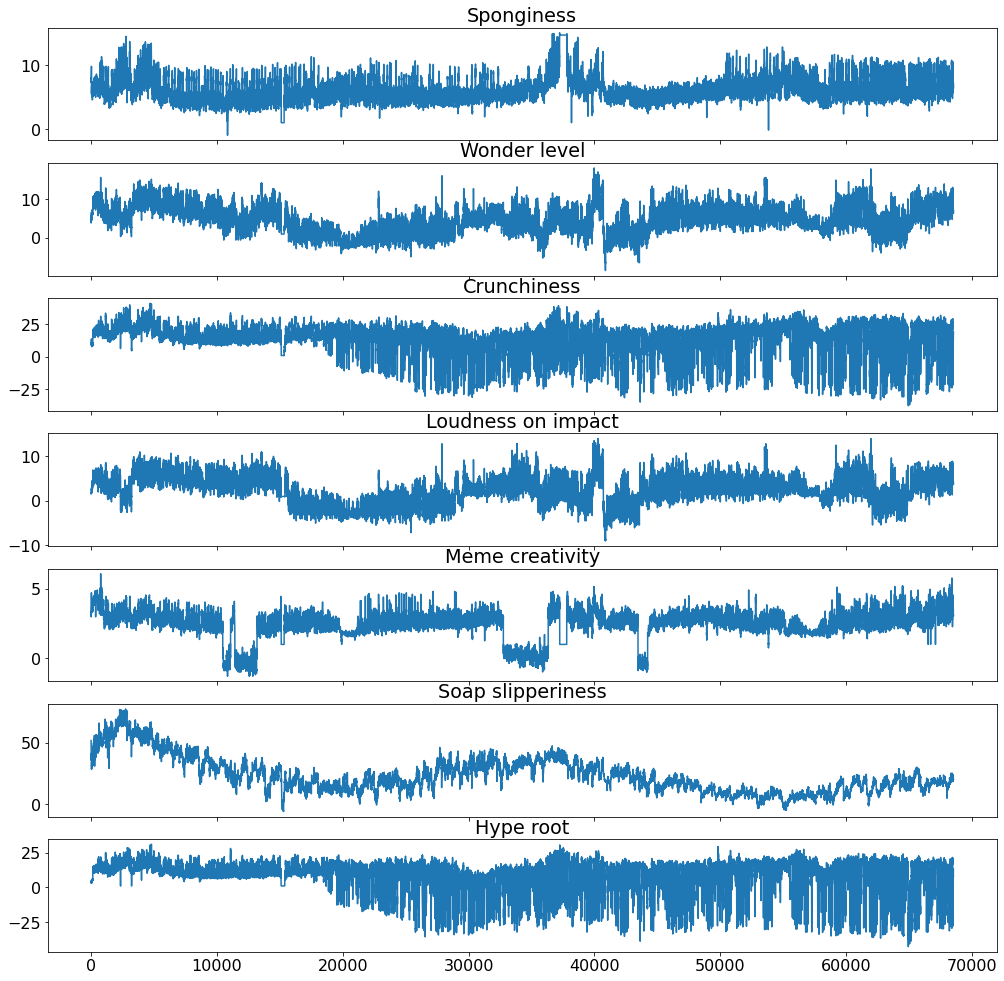

In [7]:
inspect_dataframe(dataset, dataset.columns) #WE VISUALIZE THE TRENDS IN THE VARIABLES 

# Splitting


(62028, 7) (6500, 7)


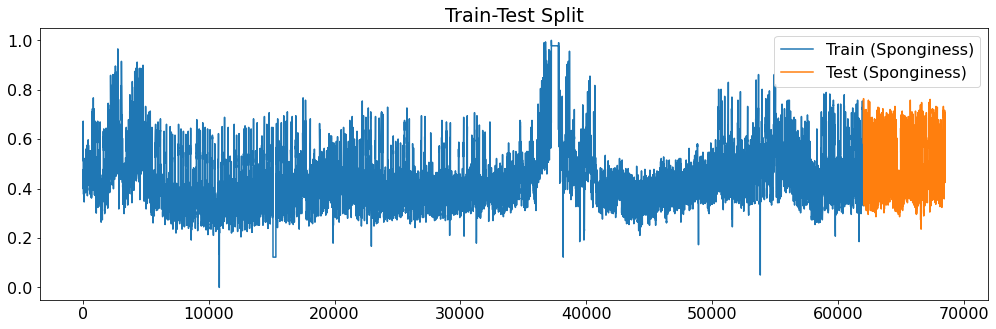

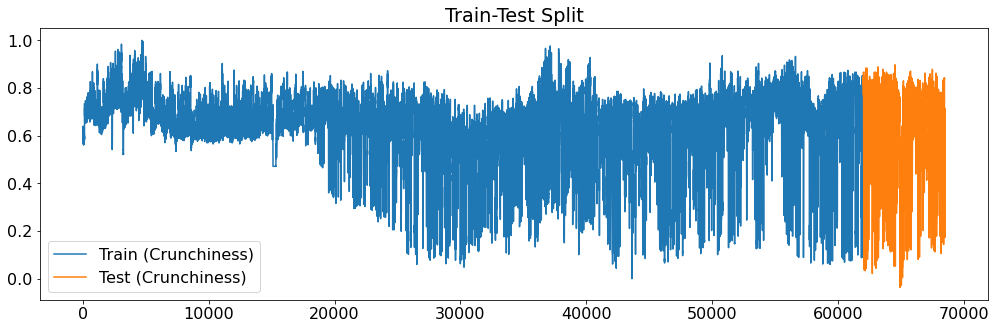

In [8]:
#THE LAST SAMPLES OF THE GIVEN SERIES ARE USED FOR TESTING,
#THE NUMBER IS CHOSEN USING SAME PROPORTION USED BY LATTARI (CIRCA 9%)
test_size = 6500
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

#THEN WE NORMALIZE IN 0 1 RANGE
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()


#Sequences (Direct Forecasting)

In [9]:
window = 2400
stride = 10

In [10]:
#THIS WILL BE USED AT END OF THE NOTEBOOK AND IS THE VERY LAST SEQUENCE AT THE END OF THE DATASET
#WILL BE USED AS STARTING POINT TO PREDICT THE FUTURE

future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 2400, 7)

In [11]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
target_labels = dataset.columns #WE TAKE ALL COLUMNS AS LABELS
telescope = 864

In [13]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

#WE CAN SEE DIMENSION OF THE CUTS AND THE DIMENSIONS OF WHAT WE WANT TO PREDICT 

((5914, 2400, 7), (5914, 864, 7), (394, 2400, 7), (394, 864, 7))

In [14]:
#WE CAN SEE SOME EXAMPLES OF WINDOWS(?) 
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

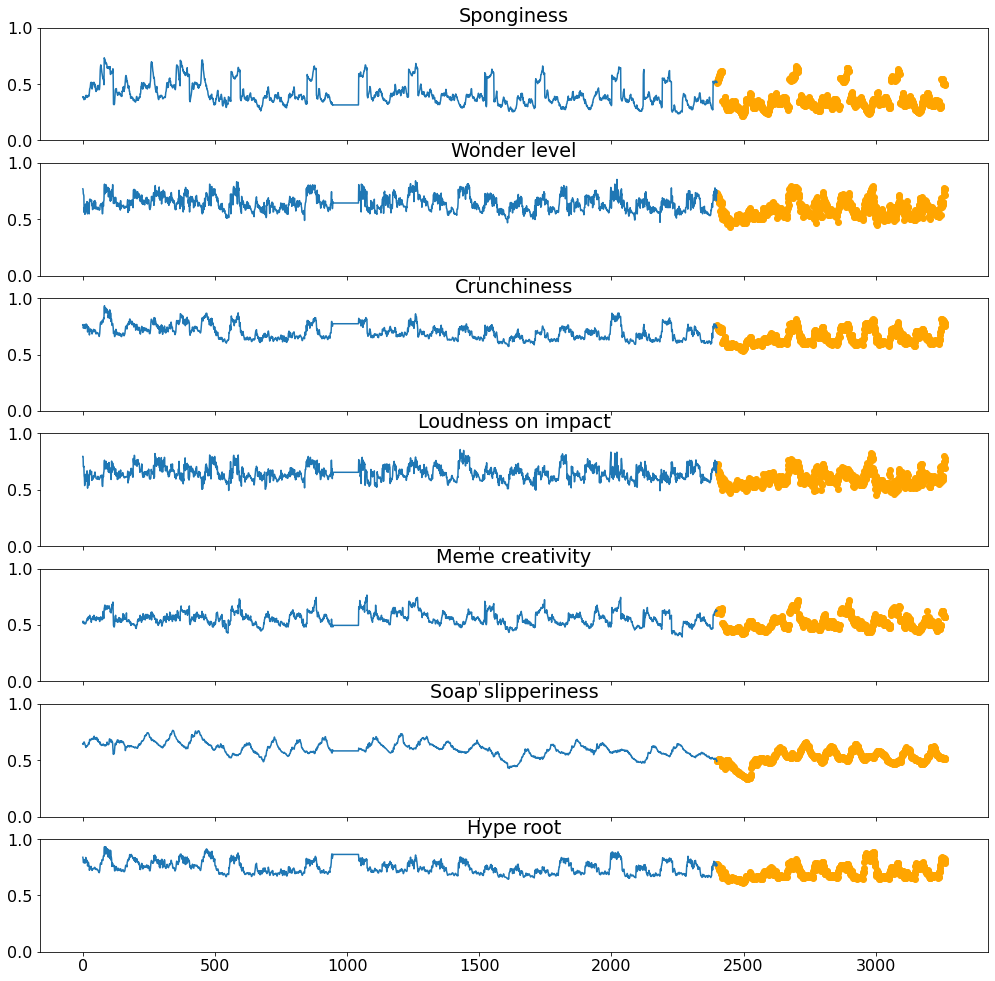

In [15]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

#Model


In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
print("output shape is", output_shape)
print("input shape is", input_shape)

output shape is (864, 7)
input shape is (2400, 7)


In [17]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #HERE WE START WITH A BIDIRECTIONAL AND WE PUT ALSO CONVO 
    #CONVO CAPTURES SPATIAL CORRELATIONS
    #LSTM CAPTURES BETTER THE TEMPORAL CORRELATIONS
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    #convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True))(convlstm)
    #convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    #convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.3)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

2022-01-21 12:40:25.342415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 12:40:25.501942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 12:40:25.502745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 12:40:25.504376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2400, 7)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2400, 512)         540672    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1200, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1200, 1024)        4198400   
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6048)              619920

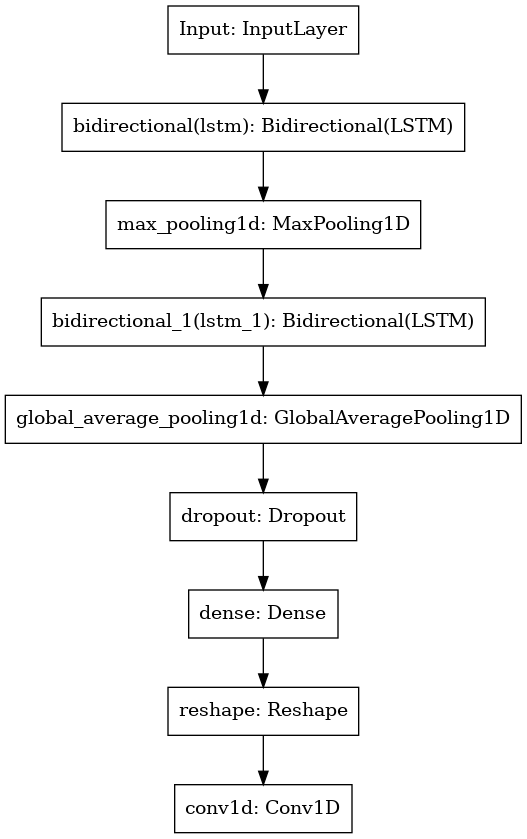

In [18]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)


In [19]:
direct_callbacks = create_folders_and_callbacks("Direct864_first")

In [20]:
# Train the model
"""
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = direct_callbacks
).history
"""

'\nhistory = model.fit(\n    x = X_train,\n    y = y_train,\n    batch_size = batch_size,\n    epochs = epochs,\n    validation_split=.1,\n    callbacks = direct_callbacks\n).history\n'

In [21]:
"""
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

"""

"\nbest_epoch = np.argmin(history['val_loss'])\nplt.figure(figsize=(17,4))\nplt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')\nplt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')\nplt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')\nplt.title('Mean Squared Error (Loss)')\nplt.legend()\nplt.grid(alpha=.3)\nplt.show()\n\nplt.figure(figsize=(17,4))\nplt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')\nplt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')\nplt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')\nplt.title('Mean Absolute Error')\nplt.legend()\nplt.grid(alpha=.3)\nplt.show()\n\nplt.figure(figsize=(18,3))\nplt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')\nplt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')\nplt.legend()\nplt.grid(alpha=.3)\nplt.show()\n\n

In [22]:
#model.save('experiments/DirectForecasting')

# ModelTesting


In [23]:
#model = tfk.models.load_model('experiments/DirectForecasting')

In [24]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)
#WE COMPUTE METRICS FOR THE TEST
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

2022-01-21 12:40:30.724870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 12:40:32.589439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(394, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.30818853>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52920216>)

In [25]:
#function to inspect our predictions compared to the test set
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

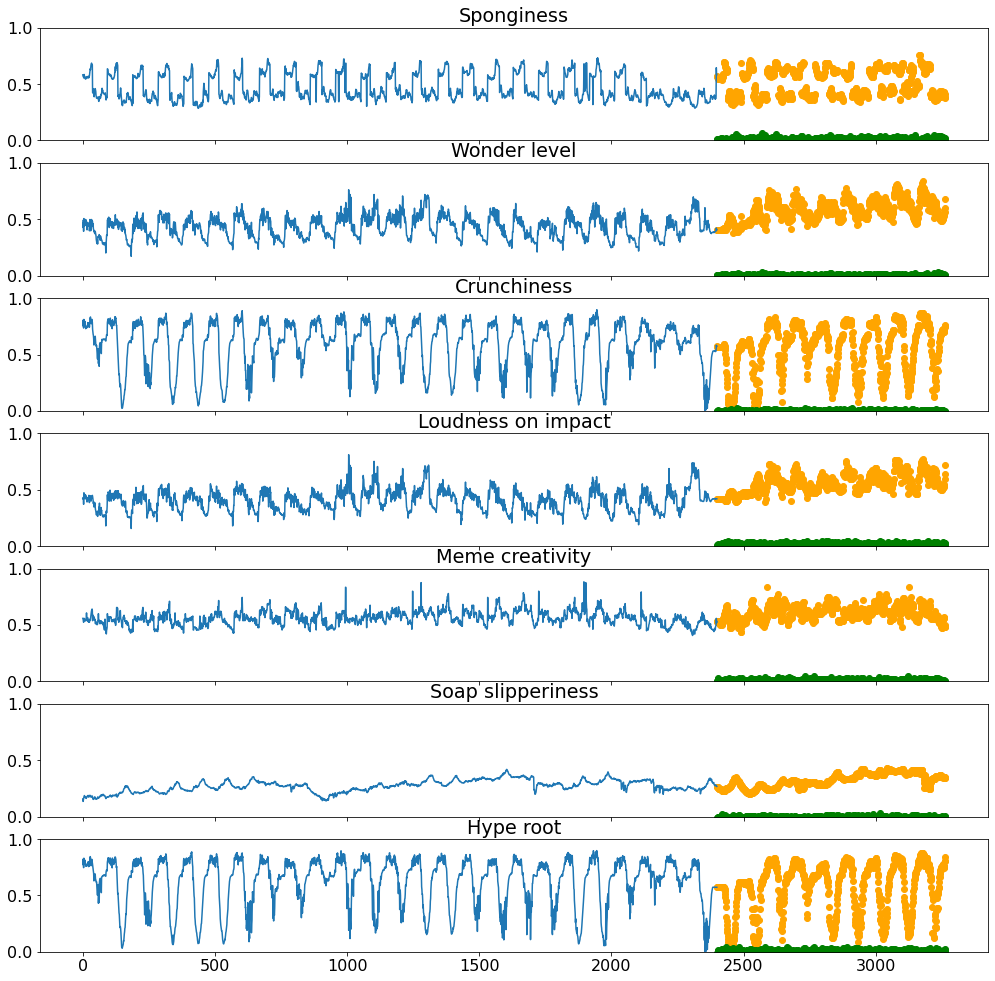

In [26]:
#BY RERUNNING CELL WE WILL SEE DIFERRENT WINDOWS 
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

# Sequences (AutoReg)


In [27]:
target_labels = dataset.columns
window =432
stride =12
telescope = 144
#WE WANT TO LEARN ONLY ONE VALUE AT A TIME
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
#WE PRINT THE SHAPES OF OUR TRAIN AND TEST SEQUENCES
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5136, 432, 7), (5136, 144, 7), (528, 432, 7), (528, 144, 7))

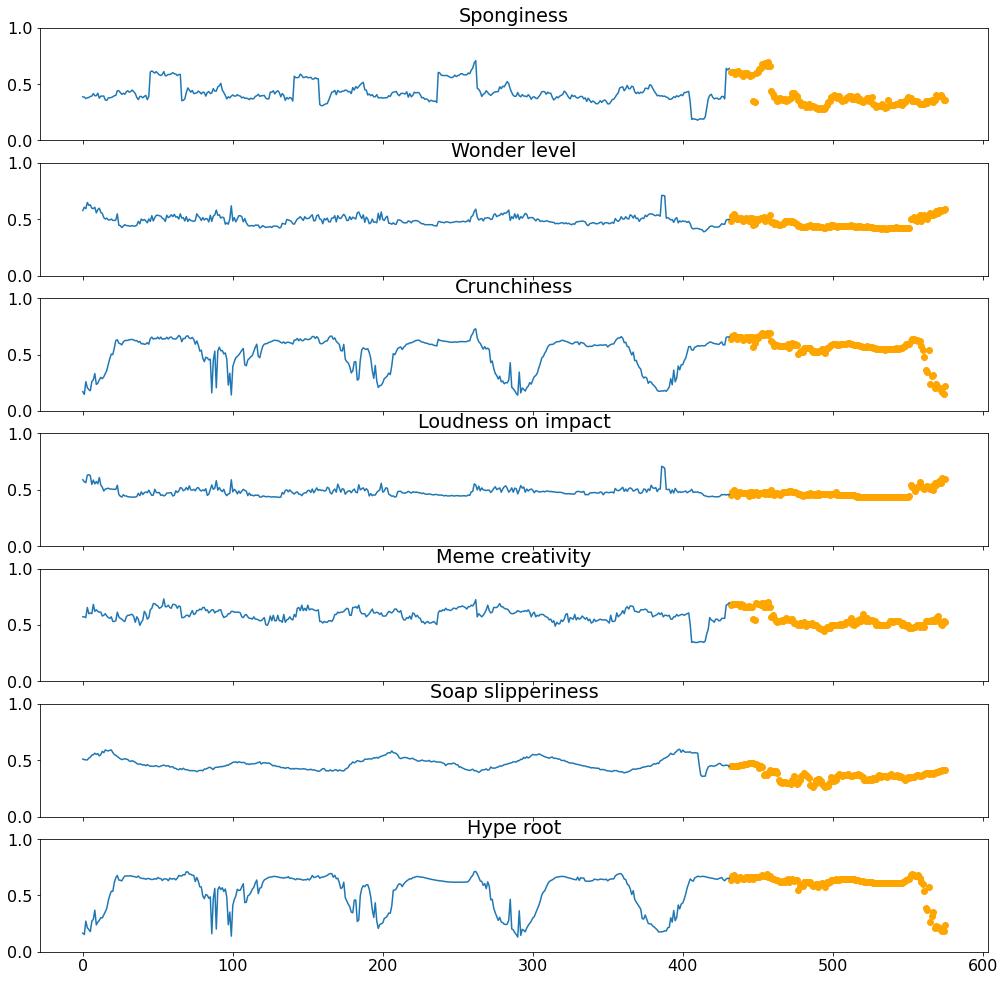

In [28]:
inspect_multivariate(X_train, y_train, target_labels, telescope)
#THE YELLOW POINT IS WHAT WE WANT TO PREDICT

In [29]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 100
print("output shape is", output_shape)
print("input shape is", input_shape)

output shape is (144, 7)
input shape is (432, 7)


# Model (Autoreg)

In [30]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #HERE WE START WITH A BIDIRECTIONAL AND WE PUT ALSO CONVO 
    #CONVO CAPTURES SPATIAL CORRELATIONS
    #LSTM CAPTURES BETTER THE TEMPORAL CORRELATIONS
    
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(512, 8, padding='same', activation='relu', use_bias=True)(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 8, padding='same', activation='relu', use_bias=True)(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(0.3)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 432, 7)]          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 432, 512)          540672    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 432, 512)          2097664   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 216, 512)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 216, 1024)         4198400   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 512)          4194816   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 512)               0     

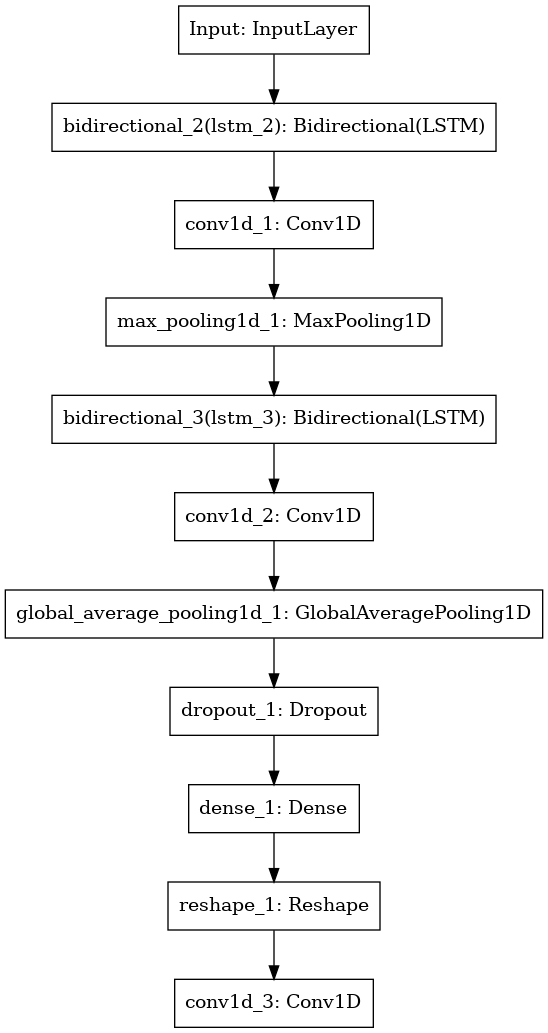

In [31]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [32]:
auto_callbacks = create_folders_and_callbacks("Autoreg_first")
print(auto_callbacks)

[<keras.callbacks.ModelCheckpoint object at 0x7f79a38531d0>, <keras.callbacks.TensorBoard object at 0x7f79a359c410>, <keras.callbacks.EarlyStopping object at 0x7f79a307a710>, <keras.callbacks.ReduceLROnPlateau object at 0x7f79a38c6d50>]


In [33]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = auto_callbacks
).history

Epoch 1/100
73/73 [==============================] - 27s 292ms/step - loss: 0.1017 - mae: 0.2554 - val_loss: 0.0446 - val_mae: 0.1638


2022-01-21 12:41:20.697846: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
73/73 [==============================] - 19s 267ms/step - loss: 0.0270 - mae: 0.1254 - val_loss: 0.0244 - val_mae: 0.1149
Epoch 3/100
73/73 [==============================] - 19s 257ms/step - loss: 0.0186 - mae: 0.1048 - val_loss: 0.0224 - val_mae: 0.1106
Epoch 4/100
73/73 [==============================] - 19s 256ms/step - loss: 0.0180 - mae: 0.1034 - val_loss: 0.0212 - val_mae: 0.1109
Epoch 5/100
73/73 [==============================] - 19s 258ms/step - loss: 0.0177 - mae: 0.1024 - val_loss: 0.0245 - val_mae: 0.1165
Epoch 6/100
73/73 [==============================] - 19s 255ms/step - loss: 0.0170 - mae: 0.1004 - val_loss: 0.0207 - val_mae: 0.1093
Epoch 7/100
73/73 [==============================] - 19s 259ms/step - loss: 0.0167 - mae: 0.0994 - val_loss: 0.0214 - val_mae: 0.1094
Epoch 8/100
73/73 [==============================] - 19s 256ms/step - loss: 0.0166 - mae: 0.0990 - val_loss: 0.0207 - val_mae: 0.1093
Epoch 9/100
73/73 [==============================] - 19s 259ms

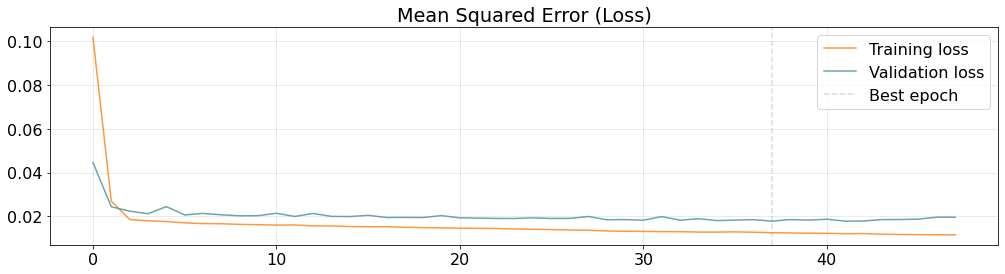

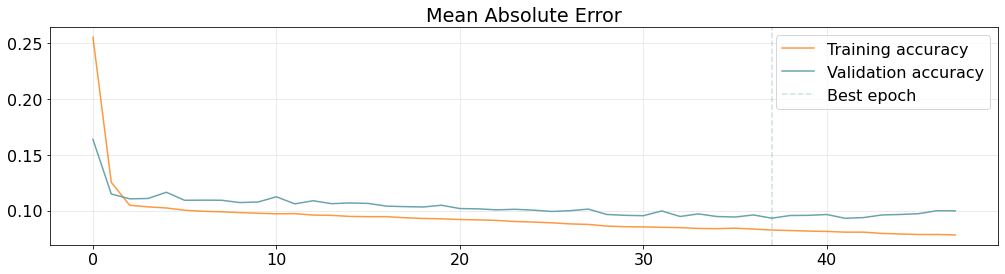

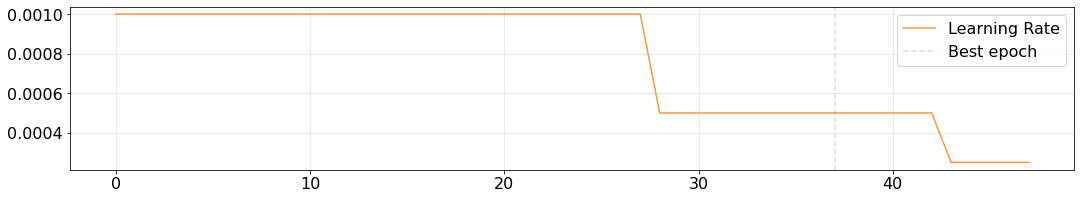

In [34]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [35]:
model.save('experiments/Autoreg_BestWeights')
#model = tfk.models.load_model('experiments/Autoreg_BestWeights')

In [36]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(528, 144, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.021224208>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10514203>)

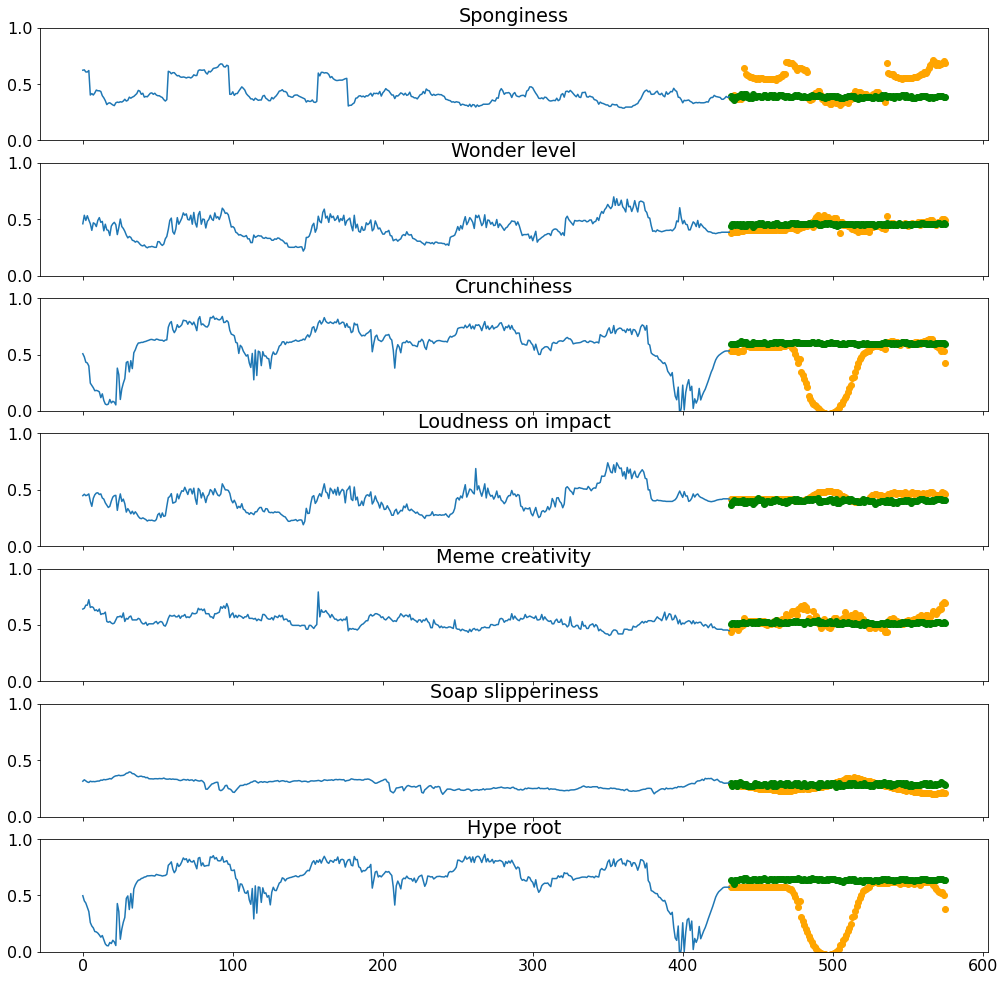

In [37]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)
#THE PREDICTIONS (GREEN) ARE QUITE SIMILAR!

In [38]:
# I TRIED TO LEARN THE 100 NEXT FROM THE MODEL MADE TO LEARN ONLY THE NEXT VALUE
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((468, 432, 7), (468, 864, 7))

In [39]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(int(reg_telescope/telescope)): #if we use a telescope autoreg>1 here we need to divide by it
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1) #I CONCATE THE LAST PREDICTION WITH THE PREVIOUS ONES
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)
    #THE INTEGER IN THE X_temp PARENTHESIS NEEDS TO BE EQUAL TO AUTOREG PREDICTION

In [40]:
reg_predictions.shape

(468, 864, 7)

In [41]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.020710325>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10571734>)

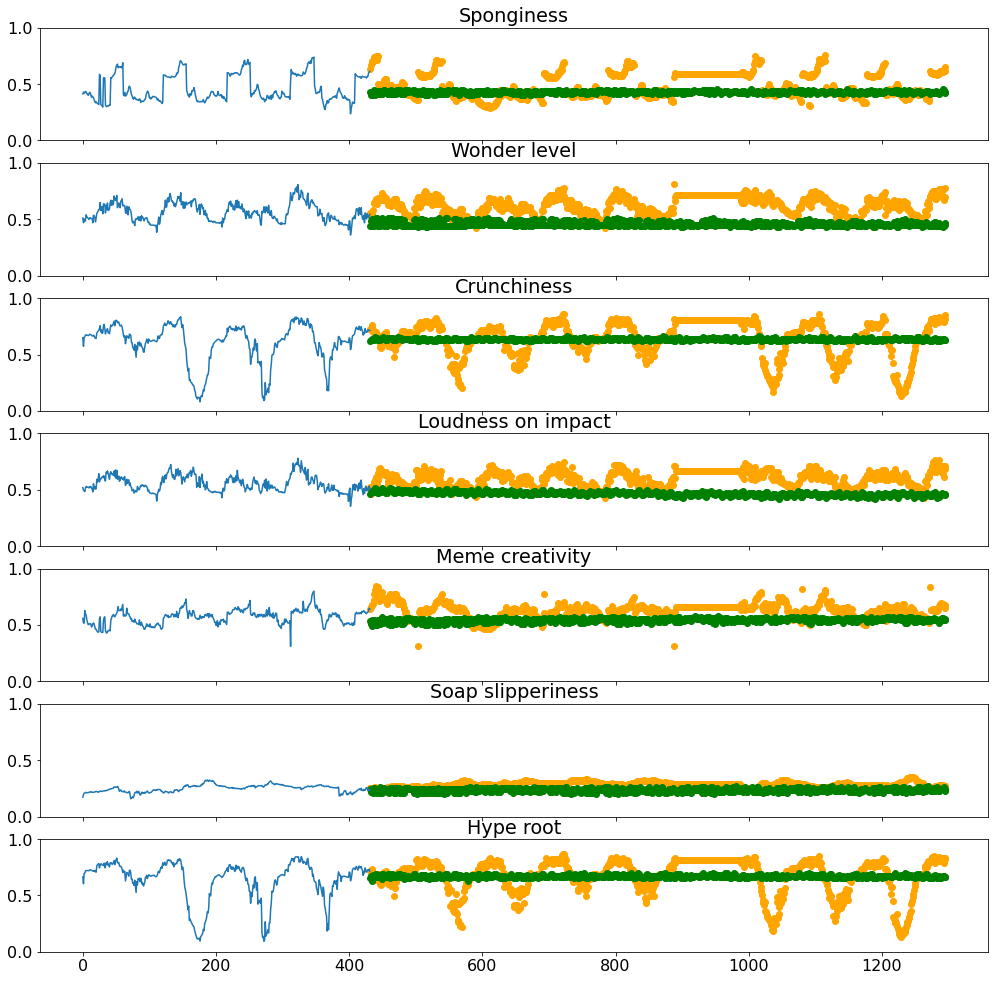

In [42]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

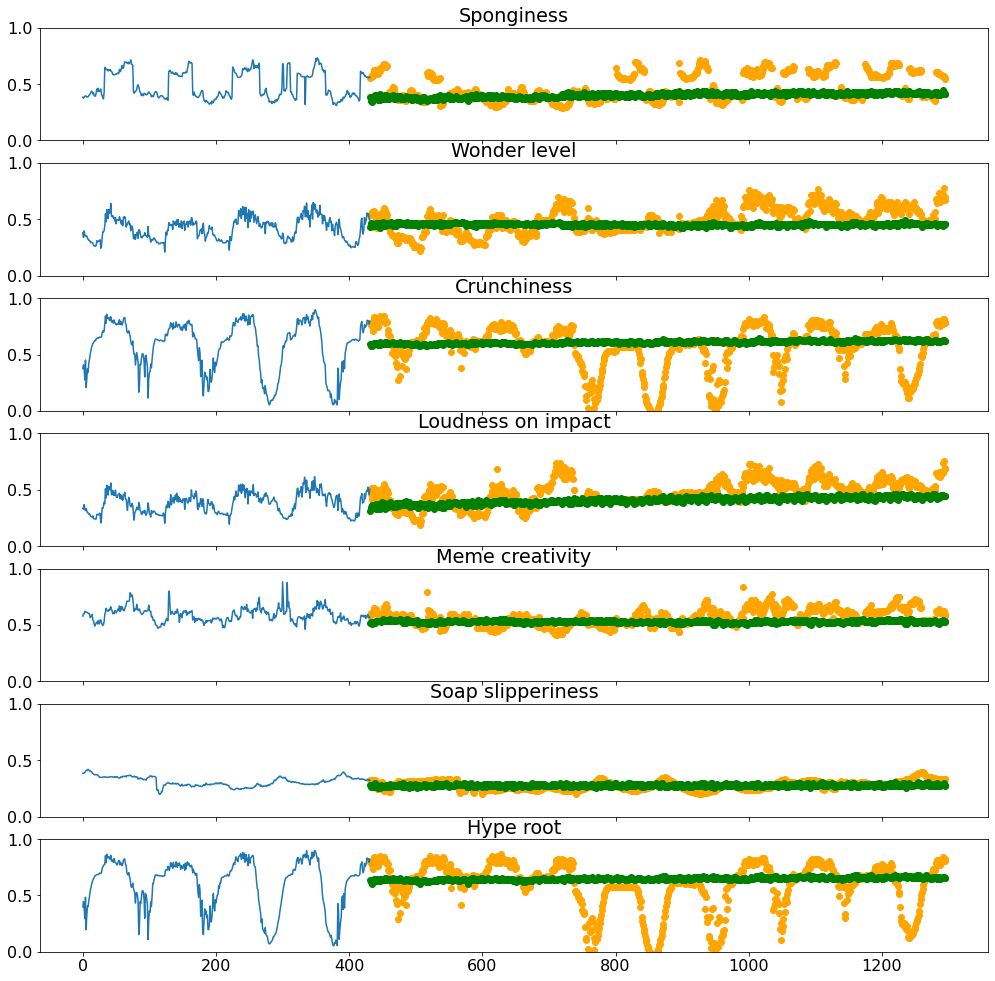

In [43]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)